In [12]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import datasets

import torch
from torch import optim

In [5]:
import torch.nn.functional as F

from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.normalization import BatchNorm
from nflows.transforms.permutations import RandomPermutation, ReversePermutation


class MaskedAutoregressiveFlow(Flow):
    """An autoregressive flow that uses affine transforms with masking.
    Reference:
    > G. Papamakarios et al., Masked Autoregressive Flow for Density Estimation,
    > Advances in Neural Information Processing Systems, 2017.
    """

    def __init__(
        self,
        features,
        hidden_features,
        context_features=None,
        num_layers=1,
        num_blocks_per_layer=1,
        use_residual_blocks=True,
        use_random_masks=False,
        use_random_permutations=False,
        activation=F.relu,
        dropout_probability=0.,
        batch_norm_within_layers=False,
        batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    context_features=context_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [6]:
seed = 42
np.random.seed(seed)

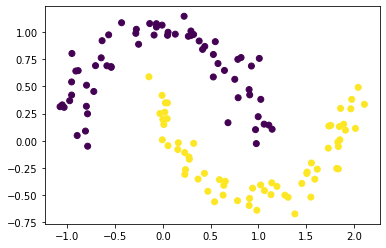

In [7]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [28]:
flow = MaskedAutoregressiveFlow(
    features=2,
    hidden_features=32,
    context_features=1,
    num_layers=3,
    num_blocks_per_layer=1,
    use_residual_blocks=True,
    use_random_masks=False,
    use_random_permutations=False,
    activation=F.relu,
    dropout_probability=0.,
    batch_norm_within_layers=False,
    batch_norm_between_layers=False,
    )

optimizer = optim.Adam(
    flow.parameters(),
    lr=1e-3,
    weight_decay=0,
    )

 10%|█████▊                                                     | 497/5000 [00:02<00:20, 222.37it/s]/tmp/ipykernel_19014/318643888.py:17: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  xline = torch.linspace(-1.5, 2.5)
/home/ADF/mdm988/.pyenv/versions/shallow/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


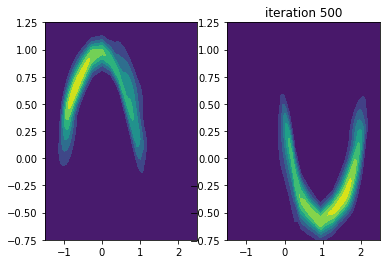

 20%|███████████▊                                               | 996/5000 [00:05<00:18, 213.59it/s]

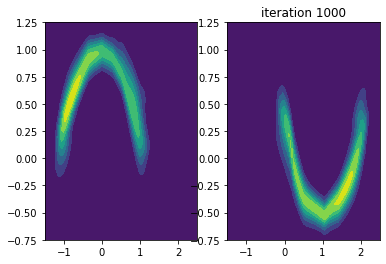

 30%|█████████████████▎                                        | 1492/5000 [00:07<00:15, 220.99it/s]

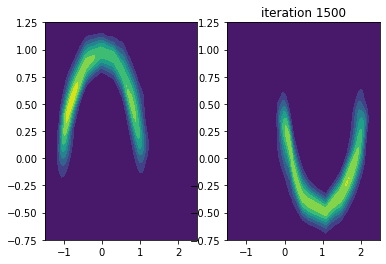

 40%|███████████████████████▏                                  | 1995/5000 [00:10<00:14, 210.95it/s]

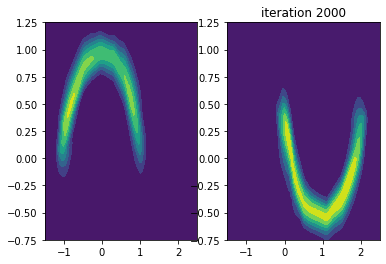

 50%|████████████████████████████▊                             | 2486/5000 [00:13<00:11, 218.40it/s]

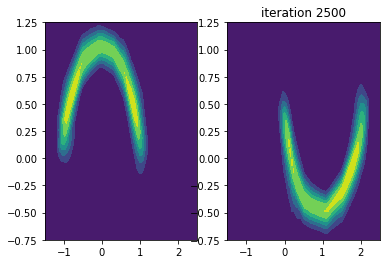

 60%|██████████████████████████████████▌                       | 2981/5000 [00:15<00:10, 184.25it/s]

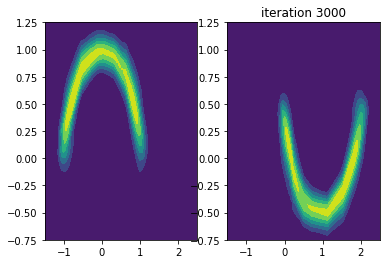

 70%|████████████████████████████████████████▌                 | 3493/5000 [00:18<00:06, 229.49it/s]

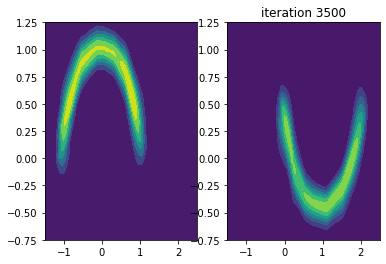

 80%|██████████████████████████████████████████████▎           | 3996/5000 [00:21<00:04, 220.62it/s]

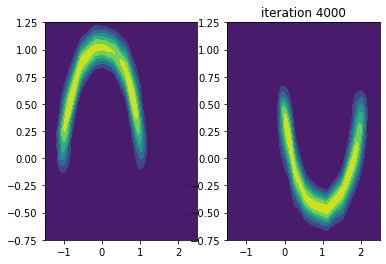

 86%|██████████████████████████████████████████████████        | 4318/5000 [00:22<00:03, 188.67it/s]


KeyboardInterrupt: 

In [6]:
num_iter = 5000

for i in tqdm(range(num_iter)):
    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()